 # Group 97 - Machine Learning (Long Notebook)
 Ilaria Crivellari, Kirill Menke, Moritz -surname-

## Search Domain Knowledge

We made some initial research about the russian house market to explore which features have the most impact on the house prices in Moscow. Thereby, we found the following papers on Google Scholar that helped us to get a better understanding of the situation:
- https://www.researchgate.net/publication/227488895_The_price_of_Moscow_apartments
- https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3374436


Moreover we found an old kaggle competition related to house price predictions in Moscow which provided some geographic-related data:
- https://www.kaggle.com/c/sberbank-russian-housing-market/discussion/35585 


As a result of studying these papers and the old kaggle competition we decided to include some additional features which will be described below.

## Loading data

In [26]:
import numpy as np
import pandas as pd
# import geopandas as gp
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import XGBRegressor, plot_importance
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.neighbors import BallTree, KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import RidgeCV, BayesianRidge
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.metrics.pairwise import haversine_distances
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

pd.options.mode.chained_assignment = None  # default='warn'

In [111]:
# Reading train/test data
apartments_train = pd.read_csv("data/apartments_train.csv")
buildings_train = pd.read_csv("data/buildings_train.csv")
apartments_test = pd.read_csv("data/apartments_test.csv")
buildings_test = pd.read_csv("data/buildings_test.csv")
metro_stations = pd.read_csv("data/metro_stations.csv")

# External datasources
sub_area_centers = pd.read_csv("data/sberbank_sub_areas.csv")
# sub_areas = gp.read_file('data/mo_kag_SRHM.shp')
sberbank_data = pd.read_csv("data/sberbank.csv")

# Merge Tables: Apartments and Buildings
train_df = apartments_train.merge(buildings_train, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')
test_df = apartments_test.merge(buildings_test, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')
print("Amount of training samples: ", len(train_df))
print("Amount of test samples: ", len(test_df))

# Merge train and test data
data_df = pd.concat([train_df, test_df])
data_df.describe()

Amount of training samples:  23285
Amount of test samples:  9937


,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,id_r,new,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,20450.000000,2.328500e+04,33222.000000,26268.000000,27321.000000,33222.000000,33222.000000,8212.000000,17111.000000,27633.000000,27633.000000,21662.000000,21662.000000,17867.000000,17867.000000,19453.000000,33102.000000,33222.000000,33222.000000,32849.000000,33220.000000,33220.000000,33067.000000,32054.000000,27579.000000,33222.000000,32685.000000,32685.000000,32685.000000,23567.000000,20985.000000,21831.000000
mean,1.855208,2.355617e+07,74.658347,12.646894,38.961378,9.033773,2.193396,1.038602,3.399897,0.749177,0.647704,0.800757,0.459699,0.564448,0.661443,1.267054,1.166093,4799.425561,4799.425561,0.327164,55.723145,37.577280,4.655276,2002.583391,2.213750,17.758082,0.403335,0.928285,0.744103,0.567785,0.793424,0.164995
std,1.089435,5.264393e+07,57.989504,6.660294,31.915799,8.216781,1.085552,0.346312,12.489861,0.790536,0.715031,0.399440,0.498385,0.642558,0.666273,1.024722,0.458706,2786.034553,2786.034553,0.469185,0.451355,1.341046,3.155880,23.156363,1.034136,11.074147,0.490574,0.258019,0.436371,0.558527,0.404858,0.551502
min,0.000000,9.000000e+05,9.300000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.141734,-61.790500,0.000000,1855.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,7.490000e+06,42.000000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2344.000000,2344.000000,0.000000,55.665969,37.496183,2.000000,1989.000000,2.000000,10.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,2.000000,1.064500e+07,59.700000,10.700000,31.000000,7.000000,2.000000,1.000000,2.800000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4752.500000,4752.500000,0.000000,55.738449,37.570479,5.000000,2013.000000,2.000000,16.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,3.000000,2.050000e+07,85.000000,15.600000,45.400000,12.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,7193.000000,7193.000000,1.000000,55.797787,37.670573,7.000000,2019.000000,3.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,3.000000,2.600000e+09,2181.000000,100.000000,900.000000,95.000000,6.000000,2.000000,350.000000,4.000000,4.000000,1.000000,1.000000,4.000000,4.000000,3.000000,2.000000,9735.000000,9735.000000,1.000000,56.006507,132.768097,11.000000,2023.000000,6.000000,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


## Exploratory Data Analysis (EDA) and Data Cleaning
We extensively explorated the data, both single features and relation between them. We derived hypotheses from our findings and decided whether to keep data that seemed unintuitive at first, or whether there is predictive power in it.



### Analyze Target Distribution
To aviod predicting negative values, the target variable was log-transformed before before fitting our models and computing the prediction error. This happens through using the TransformedTargetRegressor when building the model.

Thr results are the following price ranges:

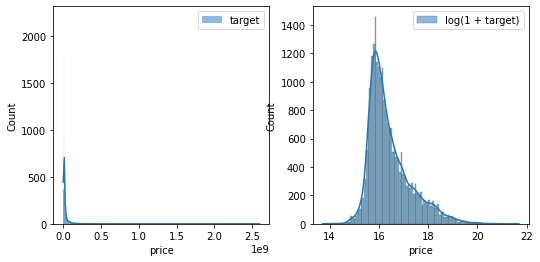

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(left=-0.2)

trans_data = pd.DataFrame(np.log1p(train_df["price"]), columns=["price"])

sns.histplot(train_df, x="price", label="target", kde=True, ax=ax1)
sns.histplot(trans_data, x="price", label="log(1 + target)", kde=True, ax=ax2)

ax1.legend()
ax2.legend();

## Analyzing Missing Data

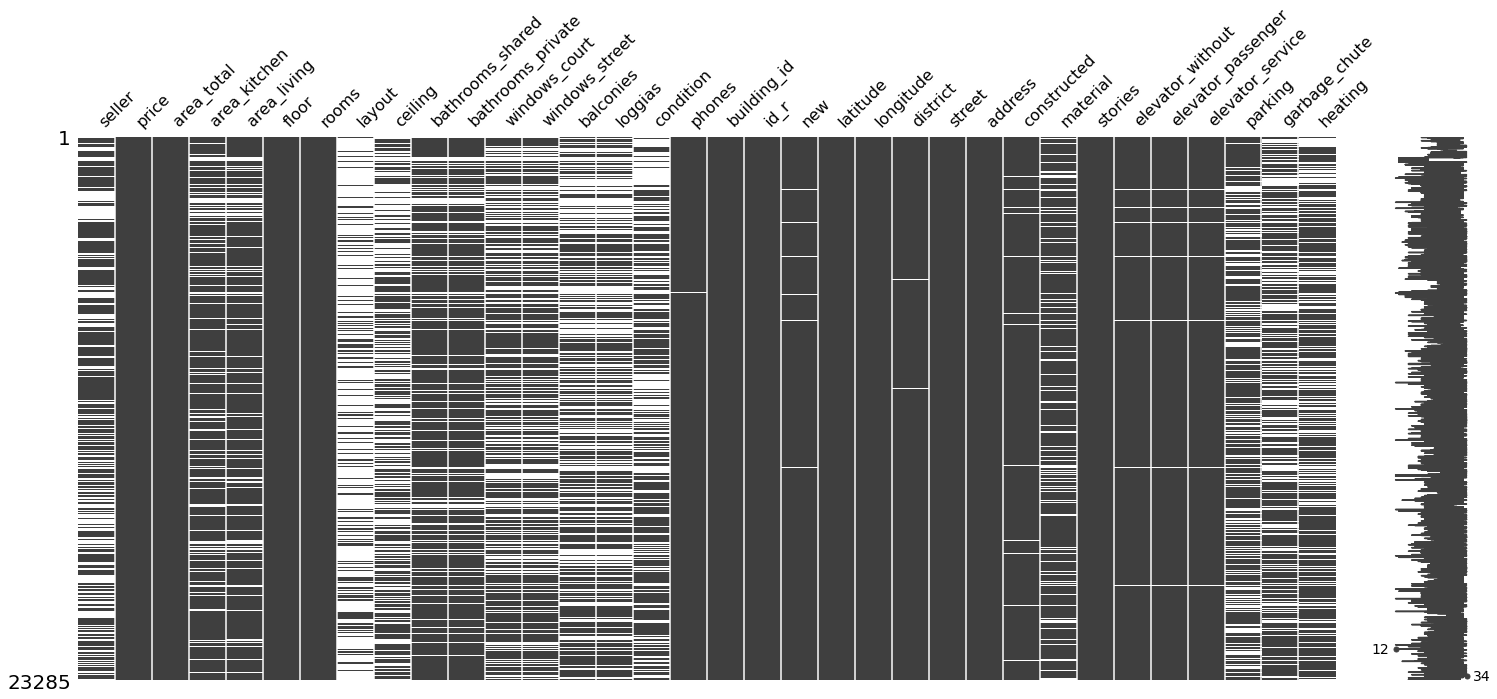

In [4]:
msno.matrix(train_df);

Analyzing the missing values, one can see that some features have more than 70% of missing values. We tried out different imputation strategies on the whole feature set to deal with that: 
- Imputing numerical features with mean/ median and catagorical features with most_frequent
- KNN imputation: Choosing the most frequent value of the nearest k neighbors in the hyperspace for imputation
- Iterative imputation: Estimates the missing values of each feature from all the other features
- Constant imputation: Imputing missing values with -999. This was chosen since the value does not appear in the value set of any feature.


Surprisingly, the best performing imputation which was also used in the final submission was the constant imputation. As we impute all the missing value with -999 – a value which is not contained in the value set of any respective feature – our tree boosting model is able to deduce information from missing values. Apparently missing values itself give a better indication for the real price.

In [8]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


np.random.seed(42)

model_lgbm = LGBMRegressor(max_depth=6, n_estimators=1200, learning_rate=0.1)
trans_lgbm = TransformedTargetRegressor(regressor=model_lgbm, func=np.log1p, inverse_func=np.expm1)

train_df['address'] = LabelEncoder().fit_transform(train_df['address'])
train_df['street'] = LabelEncoder().fit_transform(train_df['street'])

y = train_df.price
X = train_df.drop("price", axis=1)


# Constant Imputer
pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value=-999), trans_lgbm)
print("Running ConstantImputer")
ci_scores = pd.DataFrame(cross_val_score(pipe, X, y, scoring=make_scorer(rmsle)))


# Simple Imputer
categorical_columns = ["seller", "layout", "condition", "district", "material", "parking", "heating", "street", "address"]
numerical_columns = train_df.drop(categorical_columns + ["price"], axis=1).columns

imputer = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy="mean"), numerical_columns),
        ('cat', SimpleImputer(strategy="most_frequent"), categorical_columns)
])

pipe = make_pipeline(imputer, trans_lgbm)
print("Running SimpleImputer")
si_scores = pd.DataFrame(cross_val_score(pipe, X, y, scoring=make_scorer(rmsle)))


# Iterative Imputer
ii_scores = pd.DataFrame()
for estimator in [BayesianRidge()]:
    print("Running IterativeImputer", estimator.__class__.__name__)
    pipe = make_pipeline(IterativeImputer(estimator=estimator), trans_lgbm)
    ii_scores[estimator.__class__.__name__] = cross_val_score(pipe, X, y, scoring=make_scorer(rmsle))


# KNN Imputer
knn_scores = pd.DataFrame()
n_neighbors = [2, 3, 5, 7, 9]
for k in n_neighbors:
    print("Running KNNImputer", k)
    pipe = make_pipeline(KNNImputer(n_neighbors=k), trans_lgbm)
    knn_scores[f"KNN(k = {k})"] = cross_val_score(pipe, X, y, scoring=make_scorer(rmsle))


# Combine scores into single dataframe
final_scores = pd.concat([ii_scores, si_scores, ci_scores], axis=1, keys=["iterative_imputer", "simple_imputer", "constant_imputer"])

Running ConstantImputer


KeyboardInterrupt: 

NameError: name 'final_scores' is not defined

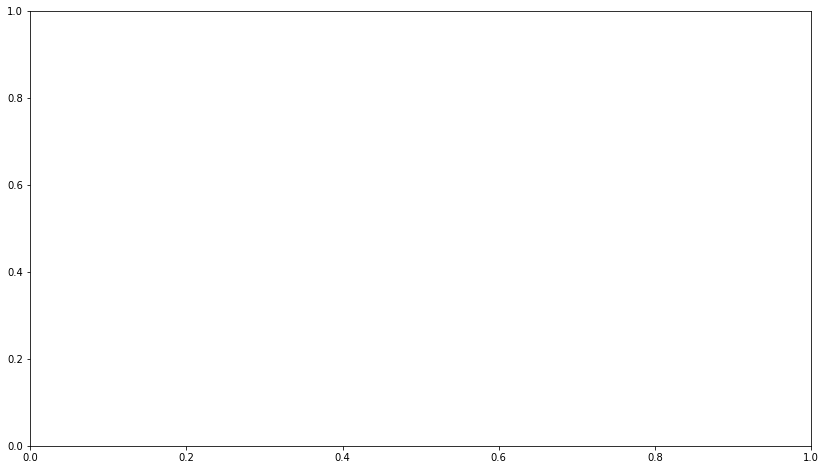

In [6]:
fig, ax = plt.subplots(figsize=(14, 8))

means, errors = final_scores.mean().sort_values(ascending=False), final_scores.std()
means.plot.barh(xerr=errors, ax=ax)

ax.set_title("Moscow House Pricing Dataset Regression With Different Imputation Methods")
ax.set_xlabel("RMSLE")
ax.set_yticks(np.arange(means.shape[0]))
plt.tight_layout(pad=1)

## Plot Correlation
Plotting the correlation between features gives important information about which features are most important for predicting the target, but also insights into relationships between features.  

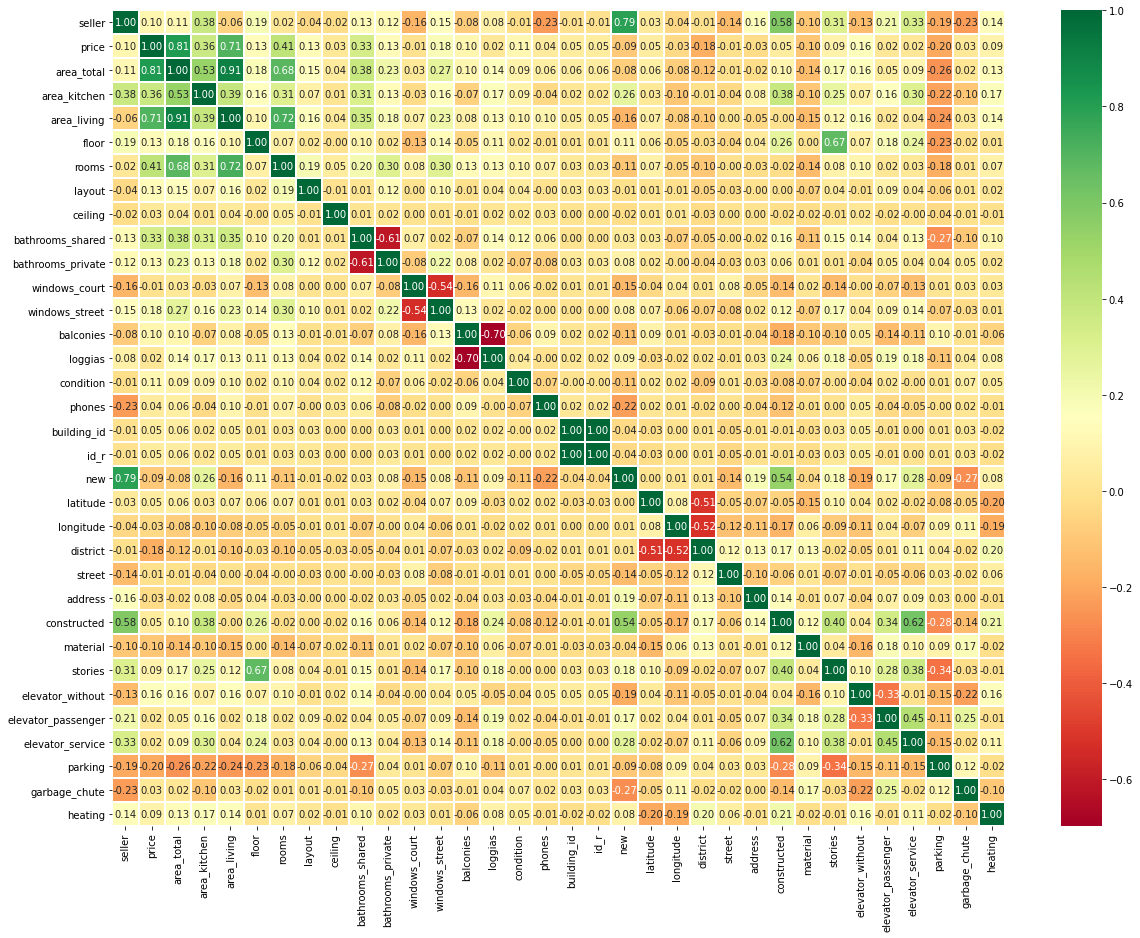

In [7]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), xticklabels=True, yticklabels=True, cmap='RdYlGn', linewidths=.2, annot=True, fmt=".2f");

From this plot we can derive insights:
- The area-related features, espeically total and living area, are highly correlated to the price. We expect them to be important.
- There is a considerable amount of features uncorrelated to the price. It might make sense to drop some of them to remove noise.
- There is strong negative correlation between balconies and loggias, as well as between windows_street and windows_court. It might make sense to add them together to gain a single feature.
- There is also negative correlation between the two types of bathrooms, but because bathrooms_shared has a considerable negative correlation to the price, we should keep them separate.

## Feature Imporatance

To confirm the insights that the correlation plot gave us, we train a gradient boosting regressor on the full dataset. This allows us to look into the feature importances and make more educated decisions about which features to keep and which to drop.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

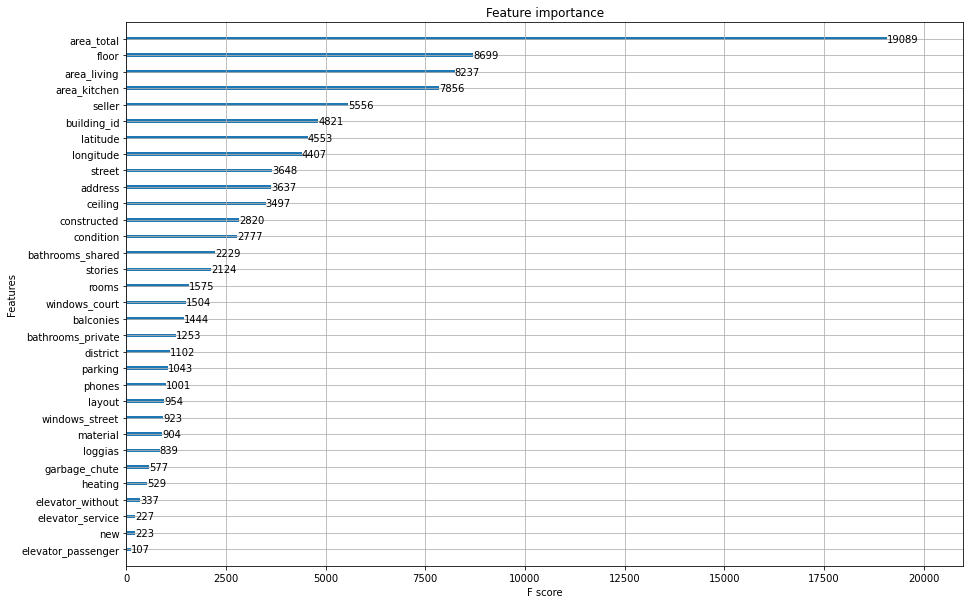

In [94]:
model_xgb = XGBRegressor(n_estimators=1200, max_depth=7, booster='gbtree')
model_xgb.fit(X, y)

fig, ax = plt.subplots(1,1,figsize=(15,10))
plot_importance(model_xgb, ax=ax)#, max_num_features=25);

As expected, the area-related features which are most correlated to the ground truth are also the  most important ones to the model. The floor exceeds out expectations in feature importance, as it was not as highly correlated to the price as the living area. We assume that the floor is a good indicator for high prices, and thus important, as apartments very high up in tall buildings are usually very costly. The least correlated ones are not of much importance.

# Ceiling
It turns out that there are several entries for ceilings which sometimes exceed hundeds of meters, as the plot below shows. We suspect that they arise from different units of measurements, as some sellers might give this information in meters and others in centimeters or decimeters.

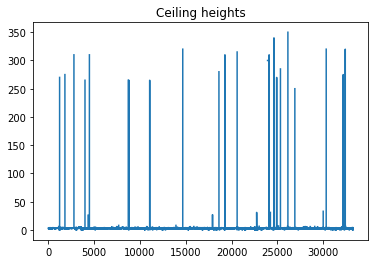

In [103]:
#CEILING
all_data = pd.concat([train_df, test_df])

plt.plot(all_data.ceiling)
_ = plt.title("Ceiling heights")

In [104]:
print("Amount of ceilings higher than 200m: ", len(all_data.ceiling[all_data.ceiling >200]))
print(all_data.ceiling[all_data.ceiling > 200].tolist())
print("Amount of ceilings between 25m and 200m: ", len(all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)]))
print(all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)].tolist())

# Rescaling out of scale ceilings
all_data.ceiling[all_data.ceiling > 200] = all_data.ceiling/100
all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)] = all_data.ceiling/10

Amount of ceilings higher than 200m:  31
[270.0, 275.0, 310.0, 265.0, 310.0, 265.0, 265.0, 265.0, 320.0, 320.0, 340.0, 310.0, 265.0, 280.0, 310.0, 315.0, 255.0, 300.0, 300.0, 310.0, 340.0, 270.0, 285.0, 350.0, 250.0, 295.0, 265.0, 320.0, 320.0, 275.0, 320.0]
Amount of ceilings between 25m and 200m:  8
[26.0, 28.0, 27.0, 27.0, 28.0, 31.0, 31.0, 33.0]


The ceilings are out of scale either by a factor of 100 or 10, so we rescale them to fit the rest of the dataset.

## Area
There are several entries in both datasets where the kitchen or living area exceed the total area of the apartment, as well as apartments with extraordinatily large or small total areas. To get a feel for this data, we plot it and check how many rows this applies to.

TEST Amount of flats with area > 1000 :  2
TEST Amount of flats with area < 10 :  0
TRAIN Amount of flats with area > 1000 :  3
TRAIN Amount of flats with area < 10 :  2
TRAIN Amount of flats with living > total :  131
TEST Amount of flats with living > total :  54
TRAIN Amount of flats with kitchen > total :  1
TEST Amount of flats with kitchen > total :  0
TRAIN Amount of flats with living+kitchen > total :  189
TEST Amount of flats with living+kitchen > total :  79


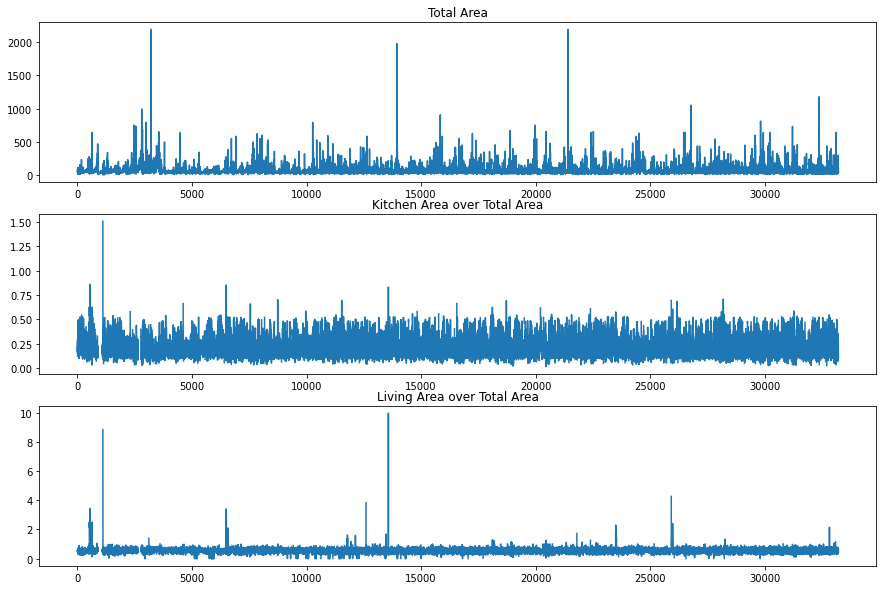

In [105]:
#AREA
fig1, axs = plt.subplots(3, figsize=(15,10))
axs[0].plot(all_data.area_total)
axs[0].set_title("Total Area")
axs[1].plot(all_data.area_kitchen/all_data.area_total)
axs[1].set_title("Kitchen Area over Total Area")
axs[2].plot(all_data.area_living/all_data.area_total)
axs[2].set_title("Living Area over Total Area")

print("TEST Amount of flats with area > 1000 : ", len(test_df.area_total[test_df.area_total >1000]))
print("TEST Amount of flats with area < 10 : ", len(test_df.area_total[test_df.area_total <10]))

print("TRAIN Amount of flats with area > 1000 : ", len(train_df.area_total[train_df.area_total >1000]))
print("TRAIN Amount of flats with area < 10 : ", len(train_df.area_total[train_df.area_total <10]))


print("TRAIN Amount of flats with living > total : ", len(train_df[train_df.area_living > train_df.area_total]))
print("TEST Amount of flats with living > total : ", len(test_df[test_df.area_living > test_df.area_total]))

print("TRAIN Amount of flats with kitchen > total : ", len(train_df[train_df.area_kitchen > train_df.area_total]))
print("TEST Amount of flats with kitchen > total : ", len(test_df[test_df.area_kitchen > test_df.area_total]))

print("TRAIN Amount of flats with living+kitchen > total : ", len(train_df[train_df.area_living + train_df.area_kitchen > train_df.area_total]))
print("TEST Amount of flats with living+kitchen > total : ", len(test_df[test_df.area_living + test_df.area_kitchen> test_df.area_total]))


#fig4, pl4 = plt.subplots(figsize=(20,10))
#pl4.bar(all_data.index[all_data.area_living>all_data.area_total], all_data.area_living[all_data.area_living>all_data.area_total]/all_data.area_total[all_data.area_living>all_data.area_total])

We can clean these entries by setting them to the standard of how big kitchens and living rooms usually are in relation to the total apartment size like this...

In [ ]:
#cleaning area data
'''
wrong_kitch_sq_index = all_data['area_kitchen'] > all_data['area_total']
all_data.loc[wrong_kitch_sq_index, 'area_kitchen'] = all_data.loc[wrong_kitch_sq_index, 'area_total'] * 1 / 3

wrong_life_sq_index = all_data['area_living'] > all_data['area_total']
all_data.loc[wrong_life_sq_index, 'area_living'] = all_data.loc[wrong_life_sq_index, 'area_total'] * 3 / 5
'''

... but when inspecting the rows where the living area is larger than the total area, we find that the majority of these entries have the same kitchen and living area and also have shared bathrooms. This is why we suspect that the large living spaces refer to common areas, so we don't correct the entries, as they provide valuable information to the model by identifying apartments with common kitchens and living areas. This was confirmed by a submission, as the score with "corrected" sizes was worse than the one with simply keeping it this way.

In [68]:
print(train_df[["area_total", "area_kitchen", "area_living", "bathrooms_shared", "bathrooms_private"]][train_df.area_living > train_df.area_total].head())
print("TRAIN Amount of flats with living > total and shared bathrooms:", len(train_df[(train_df["area_living"] > train_df["area_total"]) & (train_df["bathrooms_shared"] > 1)]))
print("TEST Amount of flats with living > total and shared bathrooms:", len(test_df[(test_df["area_living"] > test_df["area_total"]) & (test_df["bathrooms_shared"] > 1)]))

     area_total  area_kitchen  area_living  bathrooms_shared  bathrooms_private
id                                                                             
514        37.0          20.0         80.0               2.0                0.0
515        32.0          20.0         80.0               2.0                0.0
517        77.2          20.0         80.0               2.0                0.0
523        77.0          20.0         80.0               2.0                0.0
536        23.3          20.0         80.0               2.0                0.0
TRAIN Amount of flats with living > total and shared bathrooms: 107
TEST Amount of flats with living > total and shared bathrooms: 49


# DO WE INTRODUCE A BINARY VARIABLE FOR SHARED KITCHENS AND LIVING SPACES? 

## Rooms
Checking if there are apartments with zero rooms or bathrooms:

Amount of apartment with 0 rooms:  0
Amount of apartment with 0 bathrooms:  0


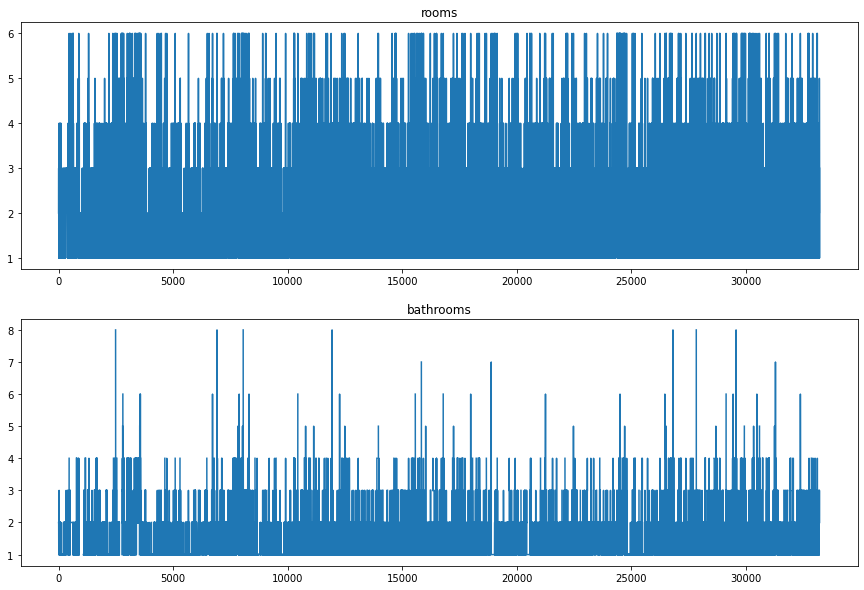

In [76]:
#ROOMS
fig1, axs = plt.subplots(2, figsize=(15,10))
axs[0].plot(all_data.rooms)
axs[0].set_title("rooms")
axs[1].plot(all_data.bathrooms_private + all_data.bathrooms_shared)
axs[1].set_title("bathrooms")

print("Amount of apartment with 0 rooms: ", len(all_data.rooms[all_data.rooms==0]))
print("Amount of apartment with 0 bathrooms: ", len(all_data[all_data.bathrooms_shared+all_data.bathrooms_private==0]))


## Construction year

In [106]:
#CONSTRUCTED
print("min construction year: ", min(all_data.constructed))
print("max construction year: ", max(all_data.constructed)) 

min construction year:  1855.0
max construction year:  2023.0


According to Mr. Khalitov (?), the data set was created in 2018. This means, that some buildigs were still in construction at that time. As it turns out, this applies to about one third of all data.

In [107]:
print("Amount of builidings unfinished at data set creation: ", len(all_data[all_data.constructed > 2018]))

Amount of builidings unfinished at data set creation:  11091


## Floor

In [112]:
print("Amount of apartment with 0 floors: ", len(all_data[all_data.stories==0]))
print("Amount of apartment with floor bigger than stories: ", len(all_data[all_data.floor>all_data.stories]))
'''
#cleaning floor MAKE IT WORSE (boh substituing floor and stories)
wrong_floor = all_data['floor'] > all_data['stories']
all_data.loc[wrong_floor, 'stories'] = all_data.loc[wrong_floor, 'floor']
'''

Amount of apartment with 0 floors:  0
Amount of apartment with floor bigger than stories:  414


"\n#cleaning floor MAKE IT WORSE (boh substituing floor and stories)\nwrong_floor = all_data['floor'] > all_data['stories']\nall_data.loc[wrong_floor, 'stories'] = all_data.loc[wrong_floor, 'floor']\n"

## Create new features


We noticed that in the test set there are coordinates far outside moscow. These are not present in the training set.

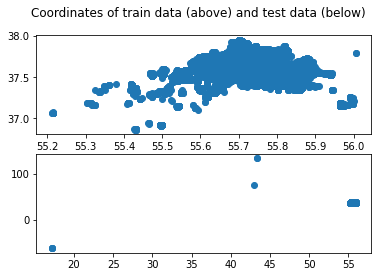

In [113]:
fig, axs = plt.subplots(2)
fig.suptitle("Coordinates of train data (above) and test data (below)")
axs[0].scatter(train_df.latitude, train_df.longitude)
axs[1].scatter(test_df.latitude, test_df.longitude)

So, with the help of the internet, we correct the wrong coordinates using their addresses. 

In [114]:
# Merge features
all_data["street_and_address"] = all_data.street + " " + all_data.address

# Imputing coordinates outside of moscow and NaNs
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 37.4821752
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица 1-я Линия 57"] = 55.6324711
all_data.longitude[all_data.street_and_address == "улица 1-я Линия 57"] = 37.4536057
all_data.latitude[all_data.street_and_address == "улица Центральная 75"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 75"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица Центральная 48"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 48"] = 37.4821752

# NaNs
all_data.latitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 55.5676692
all_data.longitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 37.4816608

TypeError: unsupported operand type(s) for +: 'int' and 'str'

We also want to add a feature that tells us how far an apartment is away from the city center. Location is very important for determining the price of an apartment, and this way, we extract more useful information from the coordinates.

First, we define a distance metric, the haversine distance. It calculates the distance between two coordinates while also considering the earth's curvature. The default arguments for lat2 and lng2 are the latitude and longitude of Moscow's city center.

In [115]:
def haversine_array(lat1, lng1, lat2 = 55.75, lng2 = 37.6):
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
        AVG_EARTH_RADIUS = 6371  # in km
        lat = lat2 - lat1
        lng = lng2 - lng1
        d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
        h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
        return h

In [116]:
# Add distance from city center
all_data['center_distance'] = haversine_array(all_data['latitude'], all_data['longitude'])

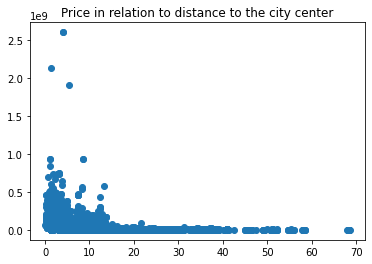

In [117]:
_ = plt.scatter(all_data.center_distance, all_data.price)
_ = plt.title("Price in relation to distance to the city center")

As we can see, generally, the closer an apartment is to the city center, the more expensive it gets.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

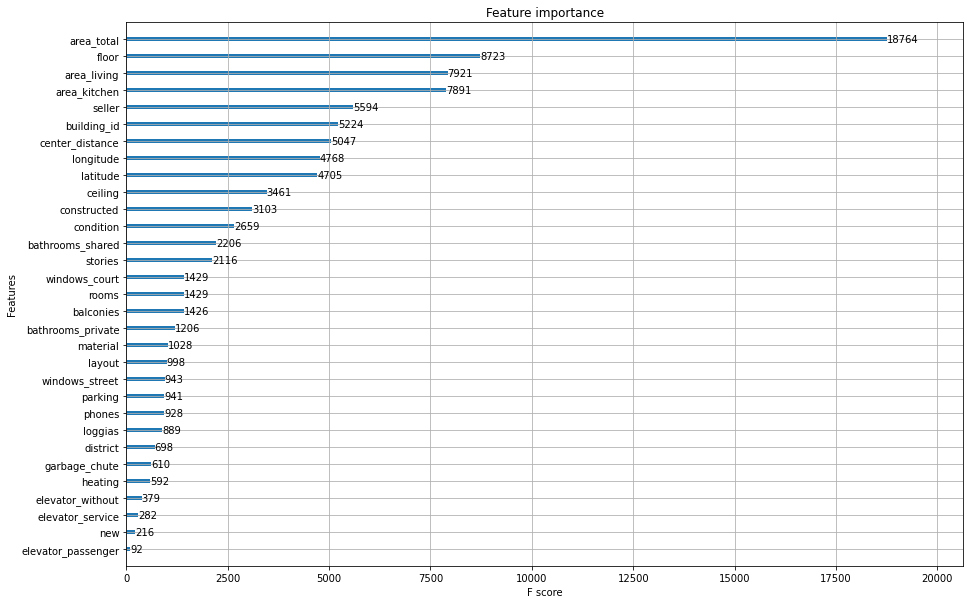

In [121]:
X = all_data[0:23285].drop(["street", "address", "price"], axis = 1)
model_xgb = XGBRegressor(n_estimators=1200, max_depth=7, booster='gbtree')
model_xgb.fit(X, y)

fig, ax = plt.subplots(1,1,figsize=(15,10))
plot_importance(model_xgb, ax=ax)#, max_num_features=25);

In [ ]:
# Encode strings to integers
all_data["street_and_address"] = LabelEncoder().fit_transform(all_data.street_and_address)

We can also add the average price that apartments in each district have.

In [17]:
# Average price per district
mean_price = train_df.groupby('district').mean().reset_index()[['district', 'price']]
train_df = train_df.merge(mean_price, how='left', on='district', suffixes=('', '_avg'))
test_df = test_df.merge(mean_price, how='left', on='district').rename(columns={'price' : 'price_avg'}).set_index(test_df.index)

We got the locations of Moscow metro stations from wikipedia. With a .csv we created, we can add a feature to every entry that holds the distances of the apartments to the nearest metro station.

In [ ]:
# Distance to nearest metro station
metro_locs = pd.read_csv("data/metro_stations.csv")[['longitude','latitude']].to_numpy()
'''
house_locs_train = train_df[['longitude','latitude']].to_numpy()
house_locs_test = test_df[['longitude','latitude']].to_numpy()
dists_train = np.min(np.linalg.norm(house_locs_train[:, np.newaxis, :] - metro_locs, axis=2), axis=1)
dists_test = np.min(np.linalg.norm(house_locs_test[:, np.newaxis, :] - metro_locs, axis=2), axis=1)
train_df['closest_metro'] = dists_train
test_df['closest_metro'] = dists_test
'''

# Add closest metro_station
bulding_locs = np.asarray(list(zip(all_data['latitude'], all_data['longitude'])))
metro_locs = np.asarray(list(zip(metro_locs['latitude'], metro_locs['longitude'])))
closest_metro_dist = np.min(haversine_distances(bulding_locs, metro_locs), axis=1)
all_data['closest_metro'] = closest_metro_dist

With the file about the subareas (raions) and their coordinates in Moscow, we can add information about which subarea the buildings belong to.

In [ ]:
# Add nearest sub_area to each building based on distance to the subarea center
sub_area_locs = np.asarray(list(zip(subareas['longitude'], subareas['latitude'])))
closest_sub_idx = np.argmin(haversine_distances(bulding_locs, sub_area_locs), axis=1)
all_data["sub_area_"] = subareas['sub_area'].iloc[closest_sub_idx].values
all_data["sub_area_"] = LabelEncoder().fit_transform(all_data['sub_area_'])

# Mapping each building to its sub_area with geopandas and the shapefile
geo_df = gp.GeoDataFrame(all_data, geometry=gp.points_from_xy(all_data.longitude, all_data.latitude))
geo_df.crs = "EPSG:4326"
all_data = gp.sjoin(sub_areas_df, geo_df, how='right', predicate='contains')
all_data = all_data.drop(["DISTRICT", "geometry", "OKATO", "OKTMO", "OKATO_AO", "index_left"], axis=1)
all_data["sub_area"] = LabelEncoder().fit_transform(all_data['sub_area'])

# Transform both to a new feature using PCA
pca = PCA(n_components=1)
all_data["sub_area_pca"] = pca.fit_transform(all_data[["sub_area", "sub_area_"]]).squeeze()
all_data = all_data.drop(["sub_area", "sub_area_"], axis=1)

Using a BallTree nearest neighbour algorithm, we also calculate the average square meter price of 300 apartments each one and add this as a feature.

In [ ]:
# Add average price in the neighborhood
tree = BallTree(all_data[["latitude", "longitude"]])
dist, ind = tree.query(all_data[["latitude", "longitude"]], k=300)

# Take log of area
all_data['area_total'] = np.log(all_data['area_total'])
mean_sqm_price = []
mean_subarea_price = []

for rows in ind:
    mean_sqm_price.append(np.nanmean(all_data['price'].iloc[rows] / all_data['area_total'].iloc[rows]))
    mean_subarea_price.append(np.nanmean(all_data['price'].iloc[rows]))

In [ ]:
all_data["mean_sqm_price"] = mean_sqm_price
# all_data["mean_subarea_price"] = mean_subarea_price

#Add floor distance from the top of the building and the percentage of the floor
all_data['floor_from_top'] = all_data['stories'] - all_data['floor']
all_data['floor_over_stories'] = all_data['floor'] / all_data['stories']

#examining year 
all_data['age_of_house_before_sale'] = np.where((2018 - all_data['constructed']>0), 2018 - all_data['constructed'], 0)
all_data['sale_before_build'] = ((2018 - all_data['constructed']) < 0).astype(int)

#Add area percentage
all_data['area_kitchen_percentage']= all_data['area_kitchen'] / all_data['area_total']
all_data['area_living_percentage']= all_data['area_living'] / all_data['area_total']